# Minimal AI Feature API Rollup Example
This notebook is intended as a bare bones example to show a straightforward case of:

* Pulling a result from the AI Feature API
* Loading the json payload into a GeoDataFrame
* Visualising the result


In [1]:
from pathlib import Path
import os
import sys

import pandas as pd
import geopandas as gpd
import shapely.wkt

sys.path.append("../")
from nmaipy.feature_api import FeatureApi
from nmaipy import constants, log, parcels

pd.set_option("display.max_rows", 1000)

import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# Store your Nearmap API Key in an environment variable so it doesn't appear in the notebook.
API_KEY = os.environ["API_KEY"]

In [3]:
# Create instance of feature API to use existing python library
feature_api = FeatureApi(
    api_key=API_KEY,
    cache_dir=None,
    system_version_prefix="gen6-",
    parcel_mode=True,
)

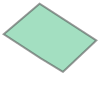

POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))


In [4]:
# Load a parcel boundary from test files
polygon = parcels.read_from_file(Path("../tests/data/test_parcels_2.csv")).iloc[5].geometry
display(polygon)
print(polygon)

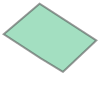

In [5]:
# Alternatively load your own boundary here
polygon = shapely.wkt.loads(
    "POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))"
)
polygon

In [6]:
# Get the API payload for that polygon as a geodataframe
features_gdf, metadata_df, error_df = feature_api.get_features_gdf(
    polygon,
    until="2024-06-20",
    region="us",
    packs=["roof_cond"],
    include=["roofSpotlightIndex", "roofConditionConfidenceStats"],
)
error_df

In [7]:
metadata_df

{'system_version': 'gen6-glowing_lantern-1.0',
 'link': 'https://apps.nearmap.com/maps/#/@40.6278218,-74.2767828,20.00z,0d/V/20240620?locationMarker',
 'date': '2024-06-20',
 'survey_id': '8d974166-3981-11ef-8a98-bf7c3ea55d9b',
 'survey_resource_id': '39234a46-877b-58fd-a4db-da0523de13c7',
 'perspective': 'Vert',
 'postcat': False}

In [8]:
features_gdf.query("description == 'Roof'").T

,4
feature_id,ca7e1039-f856-50a7-b5c5-c552c480f8cb
class_id,c08255a4-ba9f-562b-932c-ff76f2faeeeb
internal_class_id,1002
description,Roof
confidence,0.99
parent_id,61f447ae-e6cd-588a-8cd9-3305d74f77b4
geometry,POLYGON ((-74.27690953016281 40.62778324942203...
area_sqm,289.4
area_sqft,3115.0
clipped_area_sqm,288.3


<Axes: >

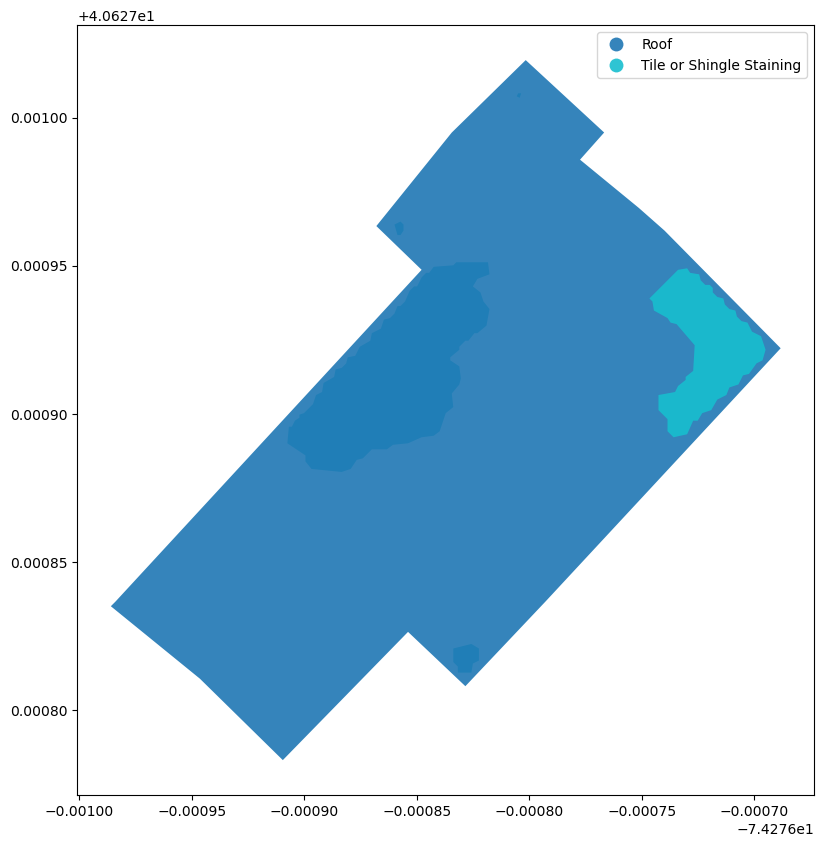

In [9]:
# Simple plot of features
features_gdf.plot("description", legend=True, figsize=(10, 10), alpha=0.9)

Testing polygon with interior hole:
Exterior coordinates: [(-74.276, 40.627), (-74.276, 40.629), (-74.278, 40.629), (-74.278, 40.627), (-74.276, 40.627)]
Interior hole coordinates: [(-74.2765, 40.6275), (-74.2765, 40.6285), (-74.2775, 40.6285), (-74.2775, 40.6275), (-74.2765, 40.6275)]

Features returned for polygon with hole: 1542


Text(0.5, 1.0, 'POST Request Result - 1542 features')

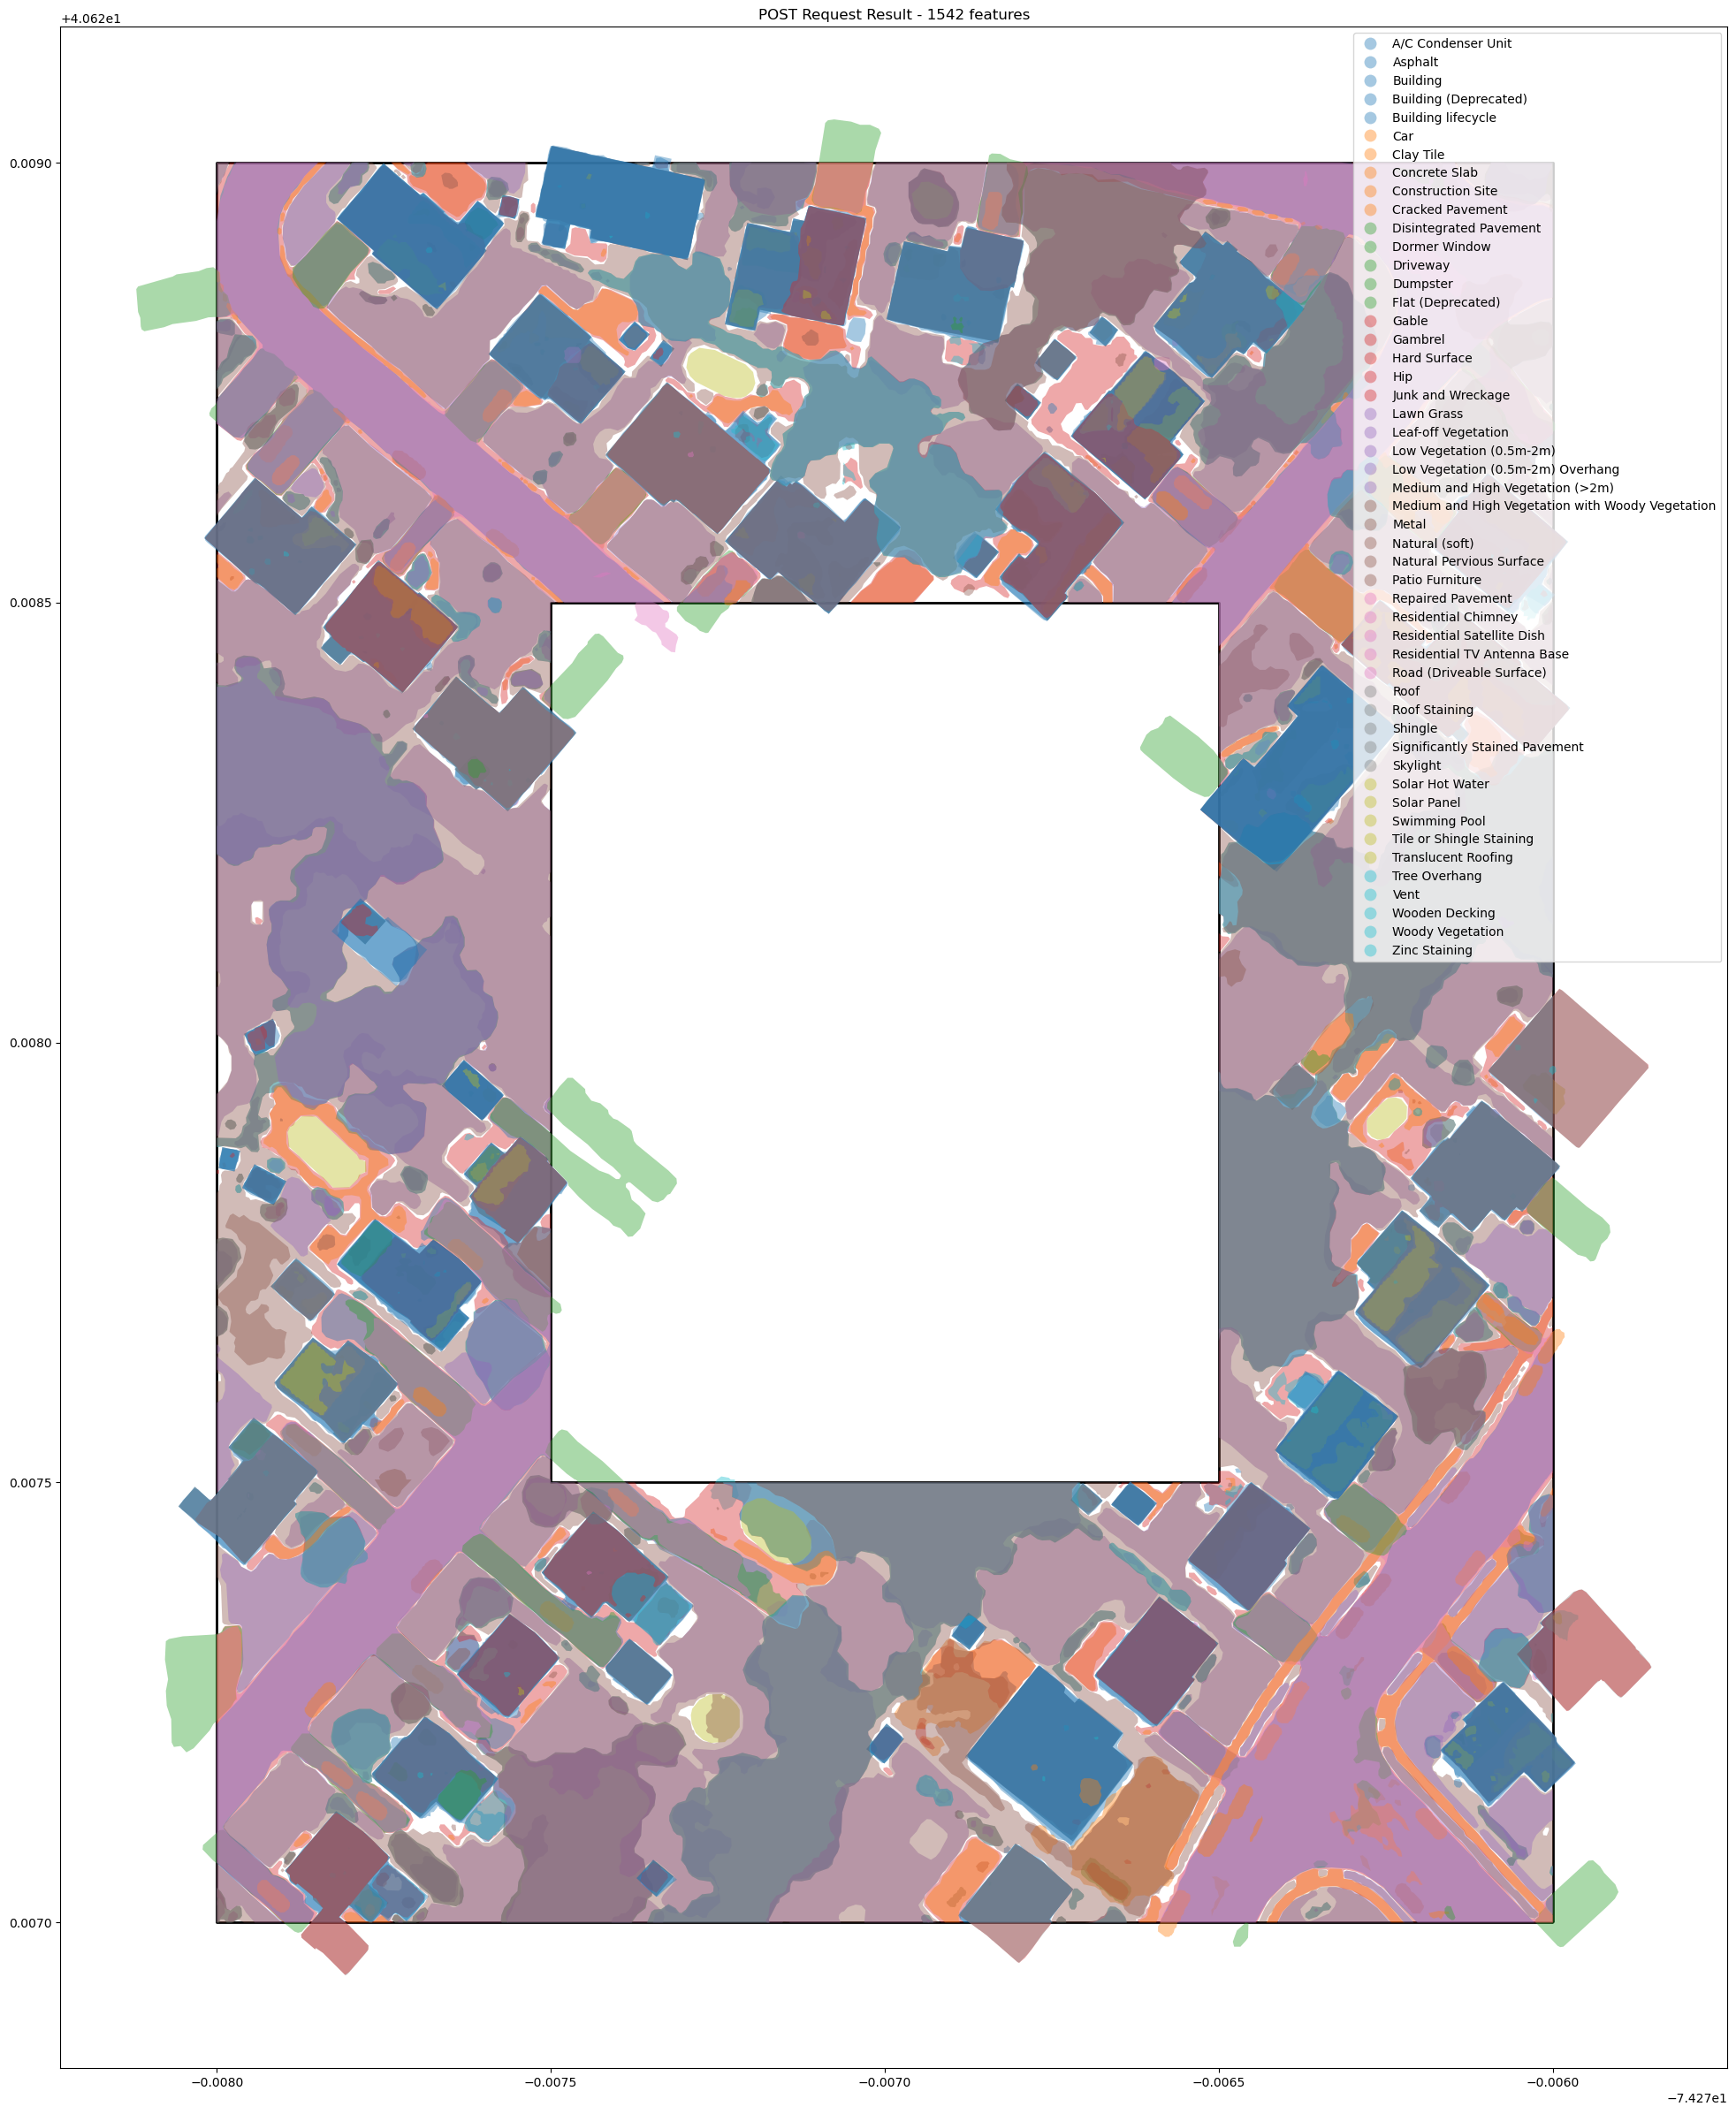

In [10]:
# Test a polygon with a hole to demonstrate the POST request capabilities
import shapely

# Create a polygon with a hole
exterior = shapely.geometry.box(-74.278, 40.627, -74.276, 40.629)
interior = shapely.geometry.box(-74.2775, 40.6275, -74.2765, 40.6285)
polygon_with_hole = shapely.geometry.Polygon(exterior.exterior.coords, [interior.exterior.coords])

print("Testing polygon with interior hole:")
print(f"Exterior coordinates: {list(exterior.exterior.coords)}")
print(f"Interior hole coordinates: {list(interior.exterior.coords)}")

# This would fail or be approximated with GET, but works with POST
features_hole_gdf, metadata_hole_df, error_hole_df = feature_api.get_features_gdf(
    polygon_with_hole,
    until="2024-06-20",
    region="us",
    # classes=[constants.BUILDING_NEW_ID, constants.ROOF_ID, constants.VEG_MEDHIGH_ID, constants.ASPHALT_ID, constants.VEG_WOODY_COMPOSITE_ID],
)
print(f"\nFeatures returned for polygon with hole: {len(features_hole_gdf)}")

# Plot both results to compare
import matplotlib.pyplot as plt

polygon_with_hole_gdf = gpd.GeoDataFrame([{"geometry": polygon_with_hole}], crs="EPSG:4326")

# Plot POST result
polygon_with_hole_gdf.plot(color='none', edgecolor='black', linewidth=2, legend=True, figsize=(30, 30))
features_hole_gdf.plot("description", alpha=0.4, legend=True, ax=plt.gca())

plt.title(f"POST Request Result - {len(features_hole_gdf)} features")

# Create parcel rollup

Once we have the features in a parcel, all that remains is to flatten the features and attributes to tabular format. Note that roof and building values relate to the primary building and roof within a parcel. The primary building is defined as the building with the largest area within the parcel.

In [11]:
df_classes = pd.DataFrame([{"description": "Roof"}], index=[constants.ROOF_ID])
df_classes

,description
c08255a4-ba9f-562b-932c-ff76f2faeeeb,Roof


In [12]:
rollup = parcels.feature_attributes(
    features_gdf, df_classes, "us", "largest_intersection", primary_decision="largest_intersection"
)
rollup

feature_id                           ca7e1039-f856-50a7-b5c5-c552c480f8cb
class_id                             c08255a4-ba9f-562b-932c-ff76f2faeeeb
internal_class_id                                                    1002
description                                                          Roof
confidence                                                           0.99
parent_id                            61f447ae-e6cd-588a-8cd9-3305d74f77b4
geometry                POLYGON ((-74.27690953016281 40.62778324942203...
area_sqm                                                            289.4
area_sqft                                                          3115.0
clipped_area_sqm                                                    288.3
clipped_area_sqft                                                  3103.0
unclipped_area_sqm                                                  289.4
unclipped_area_sqft                                                3115.0
attributes              [{'classId': '

{'roof_present': 'Y',
 'roof_count': 1,
 'roof_total_area_sqft': np.float64(3115.0),
 'roof_total_clipped_area_sqft': np.float64(3103.0),
 'roof_total_unclipped_area_sqft': np.float64(3115.0),
 'roof_confidence': np.float64(0.99),
 'roof_multiparcel_feature_count': 0,
 'primary_roof_clipped_area_sqft': np.float64(3103.0),
 'primary_roof_unclipped_area_sqft': np.float64(3115.0),
 'primary_roof_confidence': np.float64(0.99),
 'primary_roof_fidelity': np.float64(0.95869493),
 'primary_roof_multiparcel_feature': np.False_,
 'primary_roof_roof_spotlight_index': 59,
 'primary_roof_roof_spotlight_index_confidence': 0.63,
 'primary_roof_feature_id': 'ca7e1039-f856-50a7-b5c5-c552c480f8cb'}

In [13]:
df_classes = feature_api.get_feature_classes()
df_classes

,type,internalId,description,availability,schema
id,,,,,
00b83b22-a1a5-5268-99fb-62c3c3554d1d,Feature,1043,Raised Car Park,"[{'systemVersion': 'gen5-tranquil_pool-1.0', '...",NaN
00f385f3-683b-52d4-953e-02e86f2e89c7,Feature,1067,Unmaintained Swimming Pool,"[{'systemVersion': 'gen5-tranquil_pool-1.0', '...",NaN
027835c1-443c-55aa-940f-26b474cea277,Attribute,15,Pool Condition,"[{'systemVersion': 'gen5-tranquil_pool-1.0', '...","{'type': 'object', 'properties': {'classId': {..."
0339726f-081e-5a6e-b9a9-42d95c1b5c8a,Feature,1001,Swimming Pool,"[{'systemVersion': 'gen4-building_storm-2.3', ...",NaN
042a1d14-4a23-50dc-aabb-befc9645af3b,Feature,1084,Leaf-off Tree Overhang,"[{'systemVersion': 'gen5-tranquil_pool-1.0', '...",NaN
046ba67f-ca1e-5801-bb1c-bfcafea2d796,Feature,1060,Residential Satellite Dish,"[{'systemVersion': 'gen5-tranquil_pool-1.0', '...",NaN
09b925d2-df1d-599b-89f1-3ffd39df791e,Feature,1180,Bowstring Truss,"[{'systemVersion': 'gen6-glowing_grove-1.0', '...",NaN
09ed6bf9-182a-5c79-ae59-f5531181d298,Feature,1160,Clay Tile,"[{'systemVersion': 'gen6-glowing_grove-1.0', '...",NaN
0ad1355f-5dfd-403b-8b8b-b7d8ed95731f,Feature,1029,Natural (soft),"[{'systemVersion': 'gen4-building_storm-2.3', ...",NaN


In [14]:
rollup = parcels.feature_attributes(
    features_gdf, df_classes, parcel_geom=polygon, country="us", primary_decision="largest_intersection",
)

print(f"Rollup generated from Feature Api contains {len(rollup)} columns:")
display(rollup)

feature_id                           ca7e1039-f856-50a7-b5c5-c552c480f8cb
class_id                             c08255a4-ba9f-562b-932c-ff76f2faeeeb
internal_class_id                                                    1002
description                                                          Roof
confidence                                                           0.99
parent_id                            61f447ae-e6cd-588a-8cd9-3305d74f77b4
geometry                POLYGON ((-74.27690953016281 40.62778324942203...
area_sqm                                                            289.4
area_sqft                                                          3115.0
clipped_area_sqm                                                    288.3
clipped_area_sqft                                                  3103.0
unclipped_area_sqm                                                  289.4
unclipped_area_sqft                                                3115.0
attributes              [{'classId': '

Rollup generated from Feature Api contains 927 columns:


{'raised_car_park_present': 'N',
 'raised_car_park_count': 0,
 'raised_car_park_total_area_sqft': np.float64(0.0),
 'raised_car_park_total_clipped_area_sqft': np.float64(0.0),
 'raised_car_park_total_unclipped_area_sqft': np.float64(0.0),
 'raised_car_park_confidence': None,
 'unmaintained_swimming_pool_present': 'N',
 'unmaintained_swimming_pool_count': 0,
 'unmaintained_swimming_pool_total_area_sqft': np.float64(0.0),
 'unmaintained_swimming_pool_total_clipped_area_sqft': np.float64(0.0),
 'unmaintained_swimming_pool_total_unclipped_area_sqft': np.float64(0.0),
 'unmaintained_swimming_pool_confidence': None,
 'pool_condition_present': 'N',
 'pool_condition_count': 0,
 'pool_condition_total_area_sqft': np.float64(0.0),
 'pool_condition_total_clipped_area_sqft': np.float64(0.0),
 'pool_condition_total_unclipped_area_sqft': np.float64(0.0),
 'pool_condition_confidence': None,
 'swimming_pool_present': 'N',
 'swimming_pool_count': 0,
 'swimming_pool_total_area_sqft': np.float64(0.0),
 's

# Working with the Roof Spotlight Index, and Parcel Mode Clipping

The `include` parameter can be used to request additional data from the API, such as:
- `roofSpotlightIndex` - Roof Spotlight Index (RSI) data
- `roofConditionConfidenceStats` - Confidence statistics for roof condition attributes

The `parcelMode` parameter (on by default) allows not only a sub-section of a larger building to be selected using an AOI that is smaller than the building (such as parts of a commercial building, or a single property from a larger row home), but additional scores such as the RSI will also reflect that clipped area.

You can pass these as a list to the API methods like `get_features_gdf`:

,feature_id,class_id,internal_class_id,description,confidence,parent_id,geometry,area_sqm,area_sqft,clipped_area_sqm,...,unclipped_area_sqm,unclipped_area_sqft,attributes,survey_date,mesh_date,belongs_to_parcel,multiparcel_feature,fidelity,is_footprint,roof_spotlight_index
19,935c169a-ed8b-5855-8e3e-386fdfad2a56,c08255a4-ba9f-562b-932c-ff76f2faeeeb,1002,Roof,0.99,803168fa-35c5-5613-b4d9-40503d9a77b3,"POLYGON ((-74.26291 40.62345, -74.26301 40.623...",1474.1,15867.0,1465.2,...,1474.1,15867.0,[{'classId': '3065525d-3f14-5b9d-8c4c-077f1ad5...,2024-06-20,,True,False,0.926188,True,"{'value': 29, 'confidence': 0.68}"
20,9cfa29b9-b211-511b-a170-c4289a4eea77,c08255a4-ba9f-562b-932c-ff76f2faeeeb,1002,Roof,0.79,730be4a0-884d-5c0b-aca2-de1749a1739a,"POLYGON ((-74.26354 40.62323, -74.26351 40.623...",10.9,117.0,11.0,...,10.9,117.0,[{'classId': '3065525d-3f14-5b9d-8c4c-077f1ad5...,2024-06-20,,True,False,0.884890,True,"{'value': 97, 'confidence': 0.95}"


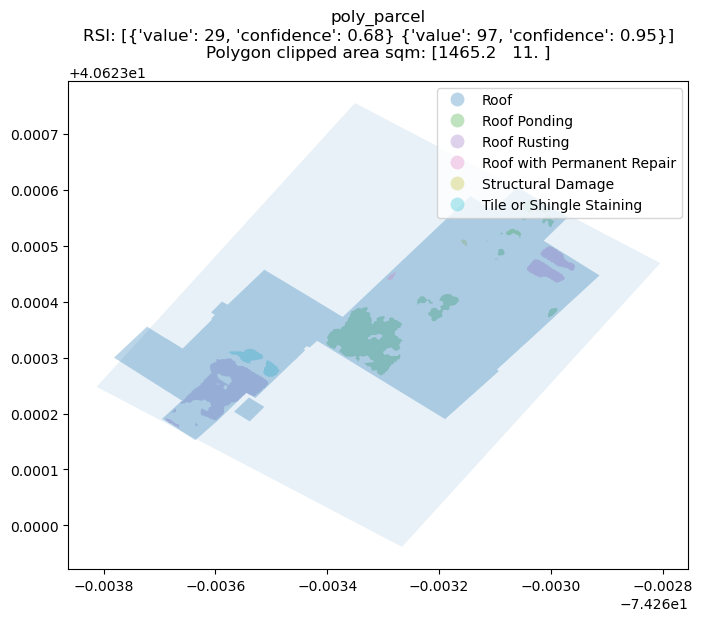

,feature_id,class_id,internal_class_id,description,confidence,parent_id,geometry,fidelity,area_sqm,area_sqft,...,clipped_area_sqft,unclipped_area_sqm,unclipped_area_sqft,attributes,survey_date,mesh_date,belongs_to_parcel,multiparcel_feature,is_footprint,roof_spotlight_index
1,935c169a-ed8b-5855-8e3e-386fdfad2a56,c08255a4-ba9f-562b-932c-ff76f2faeeeb,1002,Roof,0.99,803168fa-35c5-5613-b4d9-40503d9a77b3,"POLYGON ((-74.26378 40.6233, -74.26367 40.6232...",0.926188,1474.1,15867.0,...,1002.0,1474.1,15867.0,[{'classId': '3065525d-3f14-5b9d-8c4c-077f1ad5...,2024-06-20,,True,True,True,"{'value': 97, 'confidence': 0.95}"


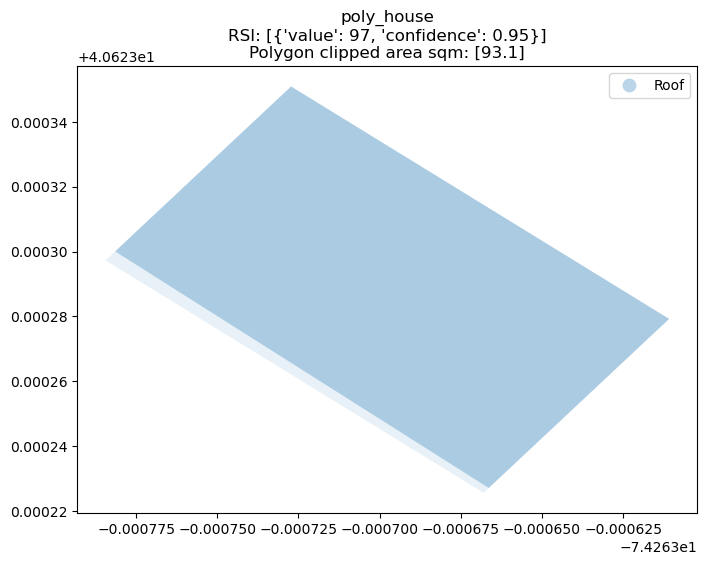

,feature_id,class_id,internal_class_id,description,confidence,parent_id,geometry,area_sqm,area_sqft,clipped_area_sqm,...,unclipped_area_sqm,unclipped_area_sqft,attributes,survey_date,mesh_date,belongs_to_parcel,multiparcel_feature,fidelity,is_footprint,roof_spotlight_index
11,935c169a-ed8b-5855-8e3e-386fdfad2a56,c08255a4-ba9f-562b-932c-ff76f2faeeeb,1002,Roof,0.99,803168fa-35c5-5613-b4d9-40503d9a77b3,"POLYGON ((-74.26342 40.62333, -74.26342 40.623...",1474.1,15867.0,486.3,...,1474.1,15867.0,[{'classId': '3065525d-3f14-5b9d-8c4c-077f1ad5...,2024-06-20,,True,True,0.926188,True,"{'value': 36, 'confidence': 0.49}"


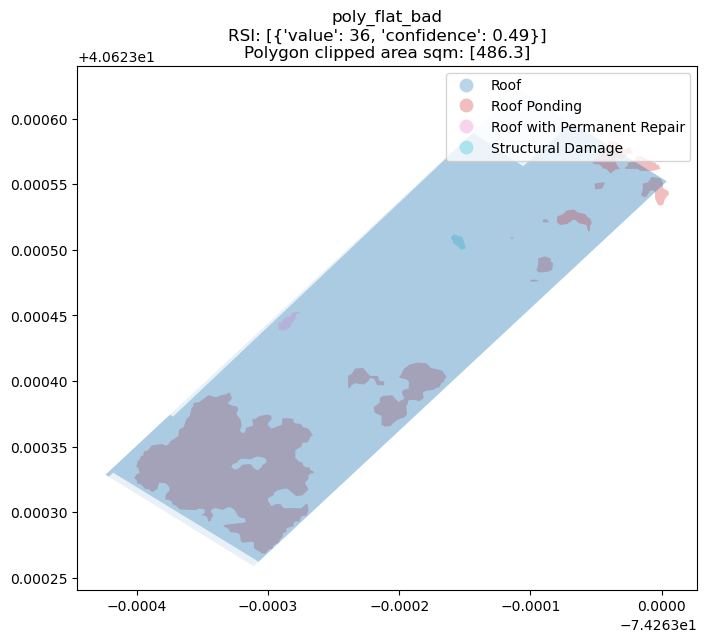

,feature_id,class_id,internal_class_id,description,confidence,parent_id,geometry,area_sqm,area_sqft,clipped_area_sqm,...,unclipped_area_sqm,unclipped_area_sqft,attributes,survey_date,mesh_date,belongs_to_parcel,multiparcel_feature,fidelity,is_footprint,roof_spotlight_index
2,935c169a-ed8b-5855-8e3e-386fdfad2a56,c08255a4-ba9f-562b-932c-ff76f2faeeeb,1002,Roof,0.99,803168fa-35c5-5613-b4d9-40503d9a77b3,"POLYGON ((-74.2633 40.62326, -74.2633 40.62326...",1474.1,15867.0,375.3,...,1474.1,15867.0,[{'classId': '3065525d-3f14-5b9d-8c4c-077f1ad5...,2024-06-20,,True,True,0.926188,True,"{'value': 87, 'confidence': 0.61}"


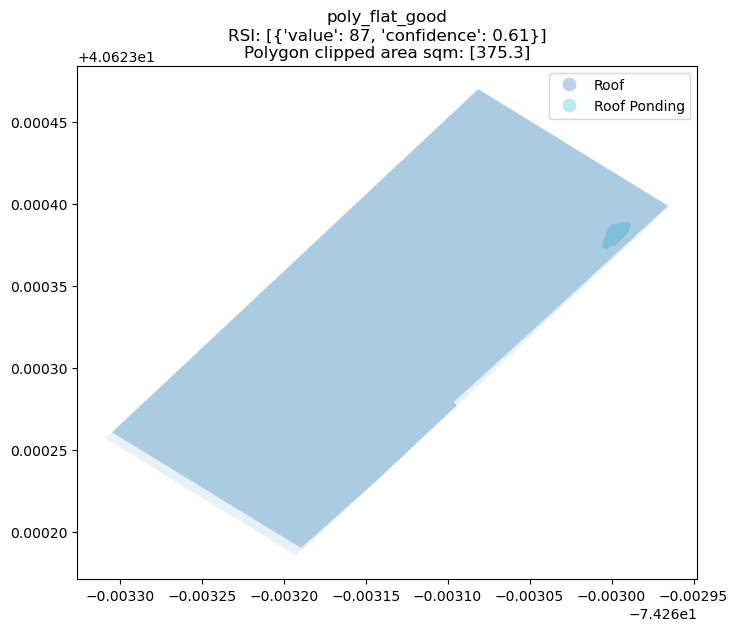

In [15]:
# Example: Get features with additional roof data using the include parameter
poly_parcel = "Polygon ((-74.26335053639306238 40.62375542341086998, -74.26280441545974043 40.62346906858068252, -74.26326638918558842 40.62296150411266638, -74.26381251011891038 40.62324786111887676, -74.26335053639306238 40.62375542341086998))"
poly_house = "Polygon ((-74.2637844347145375 40.62329727718868355, -74.26366799101872118 40.62322568810519385, -74.26361083250476725 40.62327924825357428, -74.26372727620056935 40.62335083727967344, -74.2637844347145375 40.62329727718868355))"
poly_flat_bad = "Polygon ((-74.26342389592140592 40.62332854215014777, -74.26331094553648882 40.62325872073194688, -74.26299605334918397 40.62355218240896448, -74.26310900373410107 40.62362200352039565, -74.26342389592140592 40.62332854215014777))"
poly_flat_good = "Polygon ((-74.26330861666257022 40.62325695310016016, -74.26319217296676811 40.62318536397344104, -74.26296489506734133 40.6233983336606741, -74.26308133876314344 40.62346992255913136, -74.26330861666257022 40.62325695310016016))	"
poly_dic = {
    "poly_parcel": poly_parcel,
    "poly_house": poly_house,
    "poly_flat_bad": poly_flat_bad,
    "poly_flat_good": poly_flat_good,
}

for name, p in poly_dic.items():
    p = shapely.wkt.loads(p)
    features_with_rsi_gdf, metadata_rsi_df, error_rsi_df = feature_api.get_features_gdf(
        p,
        until="2024-06-20",
        region="us",
        # Use building packs to get roof, which RSI is attached to
        packs=["building", "roof_cond"],
        # Request additional data
        include=["roofSpotlightIndex"]
    )
    feature_roof_gdf = features_with_rsi_gdf.query("description=='Roof'")
    display(feature_roof_gdf)
    ax = features_with_rsi_gdf.query("description not in ['Building', 'Building (Deprecated)']").plot("description", legend=True, figsize=(8, 8), alpha=0.3)
    gpd.GeoDataFrame(geometry=[p]).plot(ax=ax, alpha=0.1)
    plt.title(f"{name}\nRSI: {feature_roof_gdf.roof_spotlight_index.values}\nPolygon clipped area sqm: {feature_roof_gdf.clipped_area_sqm.values}")
    plt.show()
